In [3]:
!pip install nbformat
!pip install chardet

In [4]:
import pandas as pd
import os 
import requests 
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt 
import zipfile
import io
import re

### Download de la bdd parcelles bio 

In [5]:
# Dictionnaire des URLs par année
urls = {
    2022: 'https://www.data.gouv.fr/fr/datasets/r/36314eff-2712-4d6a-b091-7752a5b318bb',
    2021: 'https://www.data.gouv.fr/fr/datasets/r/e6cd3b9f-38e2-47ca-aac6-5acfb9567e01',
    2023: "https://www.data.gouv.fr/fr/datasets/r/e8639487-199c-4e30-8998-1b517148fe29",
}

# Chemins de sortie attendus (après extraction)
files_extracted = {
    2022: "data_extracted_2022/rpg-bio-2022-national.gpkg",
    2021: "data_extracted_2021/rpg-bio-2021-national.gpkg",
    2023: "data_extracted_2023/rpg-bio-2023-national/rpg-bio-2023-national.shp",
}

for year, url_zip in urls.items():
    print(f"\nTraitement de l'année {year}...")
    
    # Chemin du fichier ZIP à télécharger
    file_zip_path = f"data_{year}.zip"
    # Dossier d'extraction
    extract_path = f"data_extracted_{year}"
    # Chemin du fichier géospatial attendu (gpkg ou shp)
    file_extracted = files_extracted[year]

    # 1) Vérifier si les données existent déjà
    if os.path.exists(file_extracted):
        print(f"Les données pour l'année {year} sont déjà présentes à l'emplacement : {file_extracted}")
        gdf_temp = gpd.read_file(file_extracted).drop(columns=['geometry'], errors='ignore')
        globals()[f"gdf{year}"] = gdf_temp
        print(f"-> Lecture terminée, variable gdf{year} disponible.")
        continue  # On passe directement à l'année suivante

    # 2) Sinon, télécharger et extraire
    print(f"Téléchargement du fichier ZIP pour l'année {year} depuis {url_zip}...")
    response = requests.get(url_zip)
    if response.status_code != 200:
        print(f"Erreur lors du téléchargement pour l'année {year}: {response.status_code}")
        continue

    # Enregistrer le ZIP localement
    with open(file_zip_path, "wb") as f:
        f.write(response.content)
    
    # Vérifier si c'est bien un ZIP
    if zipfile.is_zipfile(file_zip_path):
        print(f"Extraction du fichier ZIP pour l'année {year} dans {extract_path}...")
        if not os.path.exists(extract_path):
            os.makedirs(extract_path)
        with zipfile.ZipFile(file_zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_path)

        # Vérifier que le fichier géospatial existe après extraction
        if os.path.exists(file_extracted):
            gdf_temp = gpd.read_file(file_extracted).drop(columns=['geometry'], errors='ignore')
            globals()[f"gdf{year}"] = gdf_temp
            print(f"-> Extraction et lecture terminées, variable gdf{year} disponible.")
            print(gdf_temp.head())
        else:
            print(f"Fichier {file_extracted} introuvable après extraction.")
    else:
        print(f"Le fichier téléchargé pour l'année {year} n'est pas un ZIP valide.")



Traitement de l'année 2022...
Téléchargement du fichier ZIP pour l'année 2022 depuis https://www.data.gouv.fr/fr/datasets/r/36314eff-2712-4d6a-b091-7752a5b318bb...
Extraction du fichier ZIP pour l'année 2022 dans data_extracted_2022...
-> Extraction et lecture terminées, variable gdf2022 disponible.
       gid  millesime code_culture  \
0  4420687       2022          PPH   
1      333       2022          PTR   
2      337       2022          BTH   
3      464       2022          BTH   
4      480       2022          BTH   

                                         lbl_culture           grp_culture  \
0  Prairie permanente - herbe prédominante (resso...  Prairies permanentes   
1         Autre prairie temporaire de 5 ans ou moins  Prairies temporaires   
2                                 Blé tendre d’hiver            Blé tendre   
3                                 Blé tendre d’hiver            Blé tendre   
4                                 Blé tendre d’hiver            Blé tendre   



/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: data_extracted_2023/rpg-bio-2023-national/rpg-bio-2023-national.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


-> Extraction et lecture terminées, variable gdf2023 disponible.
       gid  millesime code_cultu precision_  \
0  1057718       2023        SPH       None   
1  1057720       2023        MCR        001   
2  1057733       2023        LUZ        002   
3  1045691       2023        SPH       None   
4  1063649       2023        MLG        001   

                                          lbl_cultur         grp_cultur  \
0  Prairie avec herbe prédominante et ressources ...  Estives et landes   
1  Mélange de céréales ou pseudo-céréales d'hiver...    Autres céréales   
2                                      Autre luzerne           Fourrage   
3  Prairie avec herbe prédominante et ressources ...  Estives et landes   
4  Mélange de légumineuses prépondérantes et de g...           Fourrage   

   surface_ha code_commu         lbl_commun    code_epci code_depar  \
0        0.56      12294  Vézins-de-Lévézou  241200765.0         12   
1        2.22      12294  Vézins-de-Lévézou  241200765.0   

In [6]:
# Renommer les colonnes dans gdf2023
gdf2023.rename(columns={'code_regio': 'code_region', 'code_depar': 'code_departement'}, inplace=True)

# Vérifier les nouvelles colonnes
print("Colonnes après renommage dans gdf2023 :")
print(gdf2023.columns)


Colonnes après renommage dans gdf2023 :
Index(['gid', 'millesime', 'code_cultu', 'precision_', 'lbl_cultur',
       'grp_cultur', 'surface_ha', 'code_commu', 'lbl_commun', 'code_epci',
       'code_departement', 'code_region', 'zone_geo'],
      dtype='object')


In [7]:
# Récupérer les colonnes sous forme d'ensembles
columns_2022 = set(gdf2022.columns)
columns_2021 = set(gdf2021.columns)
columns_2023 = set(gdf2023.columns)

# Comparer les colonnes entre les trois jeux de données
common_columns = columns_2022 & columns_2021 & columns_2023  # Colonnes communes
unique_2022 = columns_2022 - (columns_2021 | columns_2023)  # Colonnes uniques à 2022
unique_2021 = columns_2021 - (columns_2022 | columns_2023)  # Colonnes uniques à 2021
unique_2023 = columns_2023 - (columns_2021 | columns_2022)  # Colonnes uniques à 2023

# Afficher les résultats
print("Colonnes communes aux trois GeoDataFrames :")
print(common_columns)

print("\nColonnes uniques à 2022 :")
print(unique_2022)

print("\nColonnes uniques à 2021 :")
print(unique_2021)

print("\nColonnes uniques à 2023 :")
print(unique_2023)


Colonnes communes aux trois GeoDataFrames :
{'millesime', 'gid', 'surface_ha', 'zone_geo', 'code_departement', 'code_region', 'code_epci'}

Colonnes uniques à 2022 :
set()

Colonnes uniques à 2021 :
set()

Colonnes uniques à 2023 :
{'code_cultu', 'precision_', 'lbl_cultur', 'lbl_commun', 'grp_cultur', 'code_commu'}


In [8]:
# Ajouter une colonne pour identifier l'année
gdf2021['annee'] = 2021
gdf2022['annee'] = 2022
gdf2023['annee'] = 2023

# Fusionner les trois GeoDataFrames en un seul DataFrame
df_combined = pd.concat([gdf2021, gdf2022, gdf2023], ignore_index=True)

# Vérifier les données fusionnées
print("Aperçu des données fusionnées :")
df_combined.head()

Aperçu des données fusionnées :


,gid,millesime,code_culture,lbl_culture,grp_culture,surface_ha,code_commune_insee,lbl_commune,code_epci,code_departement,code_region,zone_geo,annee,code_cultu,precision_,lbl_cultur,grp_cultur,code_commu,lbl_commun
0,261,2021,BTP,Blé tendre de printemps,Blé tendre,10.19,01276,Niévroz,240100610.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
1,263,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.53,01187,Haut Valromey,200040350.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
2,267,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,7.01,01187,Haut Valromey,200040350.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
3,268,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.37,01187,Haut Valromey,200040350.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN
4,274,2021,SOG,Sorgho,Autres céréales,0.59,01204,Le Poizat-Lalleyriat,200042935.0,01,84.0,France mét.,2021,NaN,NaN,NaN,NaN,NaN,NaN


### Traitement de la BDD pour achat de pesticide

In [9]:
# Liste des URLs des fichiers ZIP
urls_zip = {
    "2017": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2017.zip",
    "2018": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2018.zip",
    "2019": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2019.zip",
    "2020": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2020.zip",
    "2021": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2021.zip",
    "2022": "https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2022.zip"
}

# Dossier où seront stockés les fichiers CSV sélectionnés
output_dir = "dossier_Achats_pesticides_selected"
os.makedirs(output_dir, exist_ok=True)

# Modèle de nom de fichier cible (expression régulière)
file_pattern = r"BNVD_TRACABILITE_\d+_ACHAT_DPT_SUBSTANCE_(\d{4})\.csv"

# Boucle pour traiter chaque fichier ZIP
for year, url in urls_zip.items():
    print(f"--- Année {year} : Récupération des données depuis {url} ---")
    try:
        # Télécharger le fichier ZIP en mémoire
        response = requests.get(url)
        response.raise_for_status()
        
        # Ouvrir le fichier ZIP en mémoire
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # Filtrer pour sélectionner uniquement le fichier correspondant au modèle
            csv_files = [name for name in z.namelist() if re.search(file_pattern, name)]
            if csv_files:
                target_file = csv_files[0]  # Sélectionner le fichier correspondant
                print(f"Fichier CSV sélectionné pour {year} : {target_file}")
                
                # Construire le chemin pour sauvegarder le fichier dans le répertoire final
                output_path = os.path.join(output_dir, f"achats_pesticides_{year}.csv")
                
                # Extraire et sauvegarder le fichier CSV directement
                with z.open(target_file) as f:
                    df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")
                    df.to_csv(output_path, index=False, sep=";")
                    print(f"Fichier pour {year} sauvegardé : {output_path}")
            else:
                print(f"Aucun fichier correspondant trouvé dans l'archive ZIP pour {year}")
    except Exception as e:
        print(f"Erreur pour l'année {year} : {e}")

print("\n--- Traitement terminé. Tous les fichiers CSV sont dans le dossier : dossier_Achats_pesticides_selected ---")


--- Année 2017 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2017.zip ---
Fichier CSV sélectionné pour 2017 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2017.csv


/tmp/ipykernel_32832/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2017 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2017.csv
--- Année 2018 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2018.zip ---
Fichier CSV sélectionné pour 2018 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2018.csv


/tmp/ipykernel_32832/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2018 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2018.csv
--- Année 2019 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2019.zip ---
Fichier CSV sélectionné pour 2019 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2019.csv


/tmp/ipykernel_32832/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2019 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2019.csv
--- Année 2020 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2020.zip ---
Fichier CSV sélectionné pour 2020 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2020.csv


/tmp/ipykernel_32832/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2020 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2020.csv
--- Année 2021 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2021.zip ---
Fichier CSV sélectionné pour 2021 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2021.csv


/tmp/ipykernel_32832/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2021 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2021.csv
--- Année 2022 : Récupération des données depuis https://data.ofb.fr/catalogue/Donnees-geographiques-OFB/api/records/a69c8e76-13e1-4f87-9f9d-1705468b7221/attachments/BNVD_TRACABILITE_20231024_ACHAT_2022.zip ---
Fichier CSV sélectionné pour 2022 : BNVD_TRACABILITE_20231023_ACHAT_DPT_SUBSTANCE_2022.csv


/tmp/ipykernel_32832/1820709967.py:39: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, sep=";", encoding="utf-8", on_bad_lines="skip")


Fichier pour 2022 sauvegardé : dossier_Achats_pesticides_selected/achats_pesticides_2022.csv

--- Traitement terminé. Tous les fichiers CSV sont dans le dossier : dossier_Achats_pesticides_selected ---


In [10]:
# Répertoire contenant les fichiers CSV
input_dir = "/home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected"

# Liste des années à traiter
annees = range(2017, 2023)

# Dictionnaire pour stocker les DataFrames par année
dataframes = {}

# Boucle pour lire les fichiers de chaque année
for annee in annees:
    file_path = os.path.join(input_dir, f"achats_pesticides_{annee}.csv")
    try:
        print(f"Lecture du fichier : {file_path}")
        df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
        dataframes[annee] = df  # Stocker le DataFrame dans le dictionnaire
        print(f"Année {annee} chargée avec succès. Nombre de lignes : {len(df)}")
    except Exception as e:
        print(f"Erreur pour l'année {annee} : {e}")

# Exemple : Accéder aux données pour une année spécifique
print("\nAperçu des données de 2017 :")
dataframes[2017].head()


Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2017.csv
Année 2017 chargée avec succès. Nombre de lignes : 127088
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2018.csv


/tmp/ipykernel_32832/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_32832/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


Année 2018 chargée avec succès. Nombre de lignes : 127328
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2019.csv
Année 2019 chargée avec succès. Nombre de lignes : 112807
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2020.csv
Année 2020 chargée avec succès. Nombre de lignes : 111224
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2021.csv


/tmp/ipykernel_32832/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_32832/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")
/tmp/ipykernel_32832/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


Année 2021 chargée avec succès. Nombre de lignes : 109573
Lecture du fichier : /home/onyxia/work/AgricultureBio_France/Achats pesticides/dossier_Achats_pesticides_selected/achats_pesticides_2022.csv
Année 2022 chargée avec succès. Nombre de lignes : 106661

Aperçu des données de 2017 :


/tmp/ipykernel_32832/3120110177.py:15: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, sep=";", encoding="utf-8", on_bad_lines="skip")


,annee,code_departement,departement,amm,substance,cas,quantite_substance,classification,classification_mention,achat_etranger
0,2017,00,INDETERMINE,2179999,mesosulfuron-methyl,208465-21-8,2.77500,N Organique,NaN,Non
1,2017,00,INDETERMINE,2010618,cuivre du sulfate de cuivre,8011-63-0,247.02400,N minéral,NaN,Non
2,2017,00,INDETERMINE,2010628,trifloxystrobine,141517-21-7,1.00000,N Organique,NaN,Non
3,2017,00,INDETERMINE,2010637,"2,4-d",94-75-7,0.26040,N Organique,NaN,Non
4,2017,00,INDETERMINE,2010637,triclopyr,55335-06-3,0.29008,N Organique,NaN,Non


In [11]:
# Variables à extraire
variables = ["code_departement", "departement"]

# Créer des ensembles pour stocker les valeurs uniques
codes_departements = set()
noms_departements = set()

# Parcourir les DataFrames par année
for annee, df in dataframes.items():
    print(f"Traitement des données pour l'année {annee}")
    # Ajouter les valeurs uniques pour chaque variable, si les colonnes existent
    if "code_departement" in df.columns:
        codes_departements.update(df["code_departement"].dropna().astype(str).unique())
    if "departement" in df.columns:
        noms_departements.update(df["departement"].dropna().astype(str).unique())

# Convertir en liste pour affichage ordonné
codes_departements = sorted(list(codes_departements))
noms_departements = sorted(list(noms_departements))

# Afficher les résultats
print("\nToutes les valeurs uniques de 'code_departement' :")
print(codes_departements)

print("\nToutes les valeurs uniques de 'departement' :")
print(noms_departements)


Traitement des données pour l'année 2017
Traitement des données pour l'année 2018
Traitement des données pour l'année 2019
Traitement des données pour l'année 2020
Traitement des données pour l'année 2021
Traitement des données pour l'année 2022

Toutes les valeurs uniques de 'code_departement' :
['0', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2A', '2B', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '971', '972', '973', '974', '976']

Toutes les valeurs uniques de 'departement' :
['AIN', 'AISNE', 'ALLI

In [12]:
# Parcourir les DataFrames et supprimer les lignes avec code_departement == "00"
for annee, df in dataframes.items():
    if "code_departement" in df.columns:
        # Filtrer les lignes où code_departement est différent de "00"
        initial_rows = len(df)
        dataframes[annee] = df[df["code_departement"].astype(str) != "00"].reset_index(drop=True)
        final_rows = len(dataframes[annee])
        
        print(f"Année {annee} : {initial_rows - final_rows} lignes supprimées. Nouveau total : {final_rows} lignes.")
    else:
        print(f"Année {annee} : Colonne 'code_departement' non trouvée, aucune modification effectuée.")

print("\nSuppression terminée. Les lignes avec 'code_departement' == '00' ont été supprimées.")


Année 2017 : 722 lignes supprimées. Nouveau total : 126366 lignes.
Année 2018 : 888 lignes supprimées. Nouveau total : 126440 lignes.
Année 2019 : 526 lignes supprimées. Nouveau total : 112281 lignes.
Année 2020 : 592 lignes supprimées. Nouveau total : 110632 lignes.
Année 2021 : 664 lignes supprimées. Nouveau total : 108909 lignes.
Année 2022 : 542 lignes supprimées. Nouveau total : 106119 lignes.

Suppression terminée. Les lignes avec 'code_departement' == '00' ont été supprimées.


In [13]:
# Créer un DataFrame global pour stocker les agrégations par année et département
evolution_df = pd.DataFrame()

# Agréger les données par département et année
for annee, df in dataframes.items():
    if "code_departement" in df.columns and "quantite_substance" in df.columns:
        aggregated = df.groupby("code_departement")["quantite_substance"].sum().reset_index()
        aggregated["annee"] = annee
        evolution_df = pd.concat([evolution_df, aggregated], ignore_index=True)

# Pivot pour obtenir une colonne par année
pivot_df = evolution_df.pivot(index="code_departement", columns="annee", values="quantite_substance").fillna(0)

# Calculer les variations entre les années successives
variations_df = pivot_df.diff(axis=1).dropna(axis=1)  # Calcul des différences entre colonnes successives

# Affichage des variations
print("Variations des quantités de pesticides par département :")
print(variations_df.head())

Variations des quantités de pesticides par département :
annee                      2018          2019           2020           2021  \
code_departement                                                              
0                 285080.318476 -3.916480e+05 -720722.297263  167859.131997   
1                 187946.790448 -7.966968e+04   40081.433510    9155.048167   
2                      0.000000  0.000000e+00  608205.719704  -48738.487450   
50               -296558.647488 -3.400483e+05       0.000000       0.000000   
51                180122.382853 -2.807595e+06       0.000000       0.000000   

annee                      2022  
code_departement                 
0                -275900.715528  
1                 136470.050557  
2                -316019.858914  
50                     0.000000  
51                     0.000000  


### Travail sur les deux DF obtenus et merge des deux bases de données 

In [14]:
print("Colonnes dans variations_df :")
print(variations_df.columns)

print("\nColonnes dans df_combined :")
print(df_combined.columns)


Colonnes dans variations_df :
Index([2018, 2019, 2020, 2021, 2022], dtype='int64', name='annee')

Colonnes dans df_combined :
Index(['gid', 'millesime', 'code_culture', 'lbl_culture', 'grp_culture',
       'surface_ha', 'code_commune_insee', 'lbl_commune', 'code_epci',
       'code_departement', 'code_region', 'zone_geo', 'annee', 'code_cultu',
       'precision_', 'lbl_cultur', 'grp_cultur', 'code_commu', 'lbl_commun'],
      dtype='object')


In [15]:
# Réinitialiser l'index pour récupérer 'code_departement' comme colonne
variations_df = variations_df.reset_index()

print("Colonnes après réinitialisation de l'index :")
print(variations_df.columns)


Colonnes après réinitialisation de l'index :
Index(['code_departement', 2018, 2019, 2020, 2021, 2022], dtype='object', name='annee')


#### Harmanisation des types des deux bases de données + fusion 


In [16]:
variations_df['code_departement'] = variations_df['code_departement'].astype(str)
df_combined['code_departement'] = df_combined['code_departement'].astype(str)
df_combined = df_combined.merge(
    variations_df,
    on='code_departement',
    how='left'  # Garder toutes les lignes de df_combined
)

df_combined.head()


,gid,millesime,code_culture,lbl_culture,grp_culture,surface_ha,code_commune_insee,lbl_commune,code_epci,code_departement,...,precision_,lbl_cultur,grp_cultur,code_commu,lbl_commun,2018,2019,2020,2021,2022
0,261,2021,BTP,Blé tendre de printemps,Blé tendre,10.19,01276,Niévroz,240100610.0,01,...,NaN,NaN,NaN,NaN,NaN,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
1,263,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.53,01187,Haut Valromey,200040350.0,01,...,NaN,NaN,NaN,NaN,NaN,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
2,267,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,7.01,01187,Haut Valromey,200040350.0,01,...,NaN,NaN,NaN,NaN,NaN,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
3,268,2021,PPH,Prairie permanente - herbe prédominante (resso...,Prairies permanentes,1.37,01187,Haut Valromey,200040350.0,01,...,NaN,NaN,NaN,NaN,NaN,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894
4,274,2021,SOG,Sorgho,Autres céréales,0.59,01204,Le Poizat-Lalleyriat,200042935.0,01,...,NaN,NaN,NaN,NaN,NaN,-161053.28617,-64801.027366,49485.035649,3580.550909,-160592.55894


In [17]:
df_combined.columns

Index([               'gid',          'millesime',       'code_culture',
              'lbl_culture',        'grp_culture',         'surface_ha',
       'code_commune_insee',        'lbl_commune',          'code_epci',
         'code_departement',        'code_region',           'zone_geo',
                    'annee',         'code_cultu',         'precision_',
               'lbl_cultur',         'grp_cultur',         'code_commu',
               'lbl_commun',                 2018,                 2019,
                       2020,                 2021,                 2022],
      dtype='object')

In [18]:
# Compter les occurrences de chaque valeur dans 'grp_culture'
if 'grp_culture' in df_combined.columns:
    value_counts = df_combined['grp_culture'].value_counts()
    print("Fréquence des valeurs dans 'grp_culture' :")
    print(value_counts)
else:
    print("La colonne 'grp_culture' n'existe pas dans le DataFrame.")



Fréquence des valeurs dans 'grp_culture' :
grp_culture
Prairies permanentes                     698613
Vignes                                   245099
Fourrage                                 242724
Prairies temporaires                     220357
Autres céréales                          139630
Estives et landes                        109402
Divers                                   101623
Blé tendre                                89662
Légumes ou fleurs                         82014
Vergers                                   58365
Maïs grain et ensilage                    47318
Gel (surfaces gelées sans production)     44545
Protéagineux                              35314
Orge                                      32500
Tournesol                                 30700
Autres cultures industrielles             27787
Fruits à coque                            27000
Autres oléagineux                         24757
Oliviers                                  14093
Légumineuses à grains            

In [19]:
# Liste des départements métropolitains
metropolitan_departments = [
    '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
    '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27',
    '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40',
    '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
    '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66',
    '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79',
    '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92',
    '93', '94', '95'
]

# Convertir les codes départements en chaîne pour les comparer
df_combined['code_departement'] = df_combined['code_departement'].astype(str)

# Filtrer pour ne conserver que les départements métropolitains
df_combined = df_combined[df_combined['code_departement'].isin(metropolitan_departments)]

print("Données filtrées pour les départements métropolitains :")
print(df_combined['code_departement'].unique())


Données filtrées pour les départements métropolitains :
['01' '54' '04' '57' '38' '59' '73' '67' '11' '24' '02' '51' '03' '23'
 '83' '07' '08' '05' '84' '77' '26' '43' '13' '63' '71' '30' '37' '47'
 '46' '40' '09' '31' '15' '32' '21' '66' '65' '85' '81' '10' '17' '06'
 '55' '22' '12' '52' '48' '89' '34' '14' '61' '27' '16' '18' '78' '41'
 '58' '87' '70' '50' '19' '64' '28' '29' '86' '79' '56' '69' '62' '33'
 '25' '39' '76' '72' '82' '42' '44' '45' '35' '36' '49' '53' '88' '68'
 '60' '80' '74' '90' '91' '93' '94' '95']


In [20]:
print(df_combined.columns)


Index([               'gid',          'millesime',       'code_culture',
              'lbl_culture',        'grp_culture',         'surface_ha',
       'code_commune_insee',        'lbl_commune',          'code_epci',
         'code_departement',        'code_region',           'zone_geo',
                    'annee',         'code_cultu',         'precision_',
               'lbl_cultur',         'grp_cultur',         'code_commu',
               'lbl_commun',                 2018,                 2019,
                       2020,                 2021,                 2022],
      dtype='object')


### Début du ML 

## RANDOM FOREST REGRESSOR

In [21]:
# import des bibliothèques nécessaires à l'exécution du ML
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [22]:
# Définir la cible (surface agricole biologique)
target = 'surface_ha'

# Colonnes explicatives
features = ['code_region', 'zone_geo', 2018, 2019, 2020, 2021, 2022]

# Créer les matrices X (caractéristiques) et y (cible)
X = df_combined[features]
y = df_combined[target]
X.columns = X.columns.astype(str)


# Remplacer les valeurs manquantes
X = X.fillna(0)
y = y.fillna(0)

# Vérifier les types de données des colonnes
print("Types de données dans X avant nettoyage :")
print(X.dtypes)

# Identifier les colonnes non numériques
for col in X.select_dtypes(include=['object']).columns:
    print(f"Valeurs uniques dans {col} :")
    print(X[col].unique())

# Gestion des colonnes non numériques
if 'zone_geo' in X.columns:
    # Exemple : Remplacement de 'France mét.' ou autre valeur par un nombre
    X['zone_geo'] = X['zone_geo'].replace('France mét.', 1).astype(int)

if 'code_region' in X.columns:
    # Conversion en type entier (si applicable)
    X['code_region'] = X['code_region'].astype(int)

# Vérifier les types de données après nettoyage
print("Types de données dans X après nettoyage :")
print(X.dtypes)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



Types de données dans X avant nettoyage :
code_region    float64
zone_geo        object
2018           float64
2019           float64
2020           float64
2021           float64
2022           float64
dtype: object
Valeurs uniques dans zone_geo :
['France mét.']


/tmp/ipykernel_32832/571638868.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['zone_geo'] = X['zone_geo'].replace('France mét.', 1).astype(int)


Types de données dans X après nettoyage :
code_region      int64
zone_geo         int64
2018           float64
2019           float64
2020           float64
2021           float64
2022           float64
dtype: object


In [23]:
# Initialiser le modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [24]:
# Faire des prédictions sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Calculer les métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 164.22
R² Score: 0.01


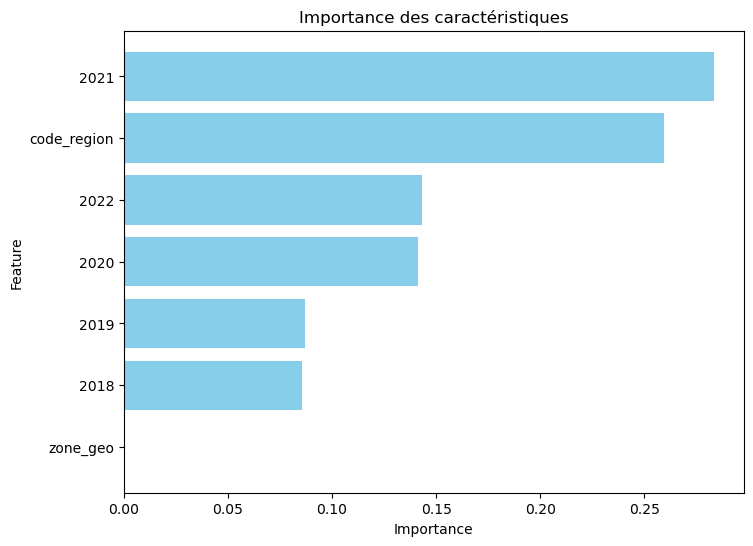

In [29]:
# Vérifier si le modèle a été entraîné et obtenir les importances des caractéristiques
feature_importances = pd.DataFrame({
    'Feature': X.columns,  # X est la matrice des caractéristiques utilisée pour entraîner le modèle
    'Importance': rf_model.feature_importances_  # rf_model est l'objet RandomForestRegressor entraîné
})

# Convertir les noms des caractéristiques en chaîne de caractères si nécessaire
feature_importances['Feature'] = feature_importances['Feature'].astype(str)

# Trier les caractéristiques par ordre d'importance décroissant
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Visualisation des importances des caractéristiques
plt.figure(figsize=(8, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Importance des caractéristiques')
plt.gca().invert_yaxis()  # Inverser l'axe pour que la caractéristique la plus importante soit en haut
plt.show()



### Analyse des Résultats du Random Forest Regressor

#### **1. Résultats obtenus :**
- **MSE (Mean Squared Error)** : 164.22  
  Cela signifie que la moyenne des écarts quadratiques entre les prédictions du modèle et les valeurs réelles est de 33.66. C'est une mesure d'erreur absolue : plus elle est faible, mieux le modèle performe.
- **R² Score** : 0.01  
  Le R² proche de 0 indique que le modèle n'explique presque pas la variance des données cibles. Cela suggère que les caractéristiques utilisées ne sont pas suffisantes ou pertinentes pour prédire la variable cible.

---

#### **2. Importance des caractéristiques :**
La visualisation montre l'importance relative des caractéristiques utilisées par le modèle pour effectuer ses prédictions :

- **`code_region` (26%) :**  
  C'est la caractéristique la plus influente. Elle peut refléter des dynamiques régionales (politiques agricoles, géographie, climat, etc.).
  
- **`2022_x` (14%) et `2021_x` (14%) :**  
  Les variations des ventes de pesticides pour ces années récentes ont également un impact significatif sur les prédictions.

- **Caractéristiques moins influentes :**  
  - `2021, `code_region`, et `2022` montrent une importance décroissante.
  - `zone_geo` a une importance nulle, suggérant qu'elle n'a aucun impact utile pour ce modèle.

---

### Conclusion :
Les résultats montrent que le modèle Random Forest struggle à généraliser les prédictions pour la cible actuelle. Cela peut être dû à plusieurs facteurs :
1. **Pertinence des données :**  
   Les variables explicatives utilisées pourraient ne pas être fortement corrélées avec la variable cible. Par exemple, les anciennes variations de pesticides (2019 et antérieures) ont un impact limité.
   
2. **Manque de complexité dans les données :**  
   Peut-être que les relations entre les variables et la cible sont plus complexes que ce que le modèle peut capturer avec ces données.

3. **Données bruitées :**  
   Des colonnes non pertinentes ou des données manquantes peuvent interférer.


Ce travail met en évidence les limitations du modèle actuel et ouvre des perspectives pour améliorer les prédictions à travers des données mieux ciblées et des modèles adaptés.



## Autre approche le *CLUSTERING* avec la méthode des k-means

In [30]:
# Vérifier les doublons par code_departement
duplicated_departements = df_combined[df_combined.duplicated(subset=['code_departement'], keep=False)]

print("Départements en doublon :")
print(duplicated_departements)


Départements en doublon :
             gid  millesime code_culture  \
0            261       2021          BTP   
1            263       2021          PPH   
2            267       2021          PPH   
3            268       2021          PPH   
4            274       2021          SOG   
...          ...        ...          ...   
3553888  1058110       2023          NaN   
3553889  1057699       2023          NaN   
3553890  1057706       2023          NaN   
3553891  1057715       2023          NaN   
3553892  1063879       2023          NaN   

                                               lbl_culture  \
0                                  Blé tendre de printemps   
1        Prairie permanente - herbe prédominante (resso...   
2        Prairie permanente - herbe prédominante (resso...   
3        Prairie permanente - herbe prédominante (resso...   
4                                                   Sorgho   
...                                                    ...   
3553888    

In [31]:
print(df_combined.columns)


Index([               'gid',          'millesime',       'code_culture',
              'lbl_culture',        'grp_culture',         'surface_ha',
       'code_commune_insee',        'lbl_commune',          'code_epci',
         'code_departement',        'code_region',           'zone_geo',
                    'annee',         'code_cultu',         'precision_',
               'lbl_cultur',         'grp_cultur',         'code_commu',
               'lbl_commun',                 2018,                 2019,
                       2020,                 2021,                 2022],
      dtype='object')


In [32]:
# Agréger les données par département
df_aggregated = df_combined.groupby('code_departement', as_index=False).agg({
    'surface_ha': 'sum',  #somme des surfaces agricoles
     2018 : 'mean',     # Moyenne des variations de pesticides
     2019 : 'mean',
     2020 : 'mean',
     2021 : 'mean',
     2022 : 'mean',
    # Ajouter d'autres colonnes numériques ici
    'zone_geo': 'first',  # Garder la première valeur (si non numérique)
   
})

# Vérifier les départements uniques après agrégation
print(df_aggregated['code_departement'].nunique())


92


In [33]:
# Calculer la fréquence des cultures par département
grp_culture_frequency = df_combined.groupby(['code_departement', 'grp_culture']).size().unstack(fill_value=0)

# Fusionner avec le DataFrame agrégé
df_aggregated = df_aggregated.merge(grp_culture_frequency, on='code_departement', how='left')

df_aggregated.head()

,code_departement,surface_ha,2018,2019,2020,2021,2022,zone_geo,Autres cultures industrielles,Autres céréales,...,Oliviers,Orge,Plantes à fibres,Prairies permanentes,Prairies temporaires,Protéagineux,Riz,Tournesol,Vergers,Vignes
0,01,62679.79,-161053.286170,-64801.027366,49485.035649,3580.550909,-160592.558940,France mét.,56,947,...,0,329,5,7468,1463,76,1,163,150,540
1,02,33632.30,398230.462851,-855026.230681,-214100.814510,289657.273504,226889.055315,France mét.,41,578,...,0,135,12,2220,504,143,0,39,197,441
2,03,68748.77,7512.571321,-116099.470325,66417.453042,22191.222494,9142.918036,France mét.,54,1207,...,0,105,11,6016,1906,212,0,115,171,127
3,04,152819.96,71175.303742,-52219.272804,4597.614843,-42276.536929,24650.676254,France mét.,2016,1571,...,1320,517,13,7070,1397,55,0,128,896,362
4,05,113855.59,33423.736388,-19639.647290,7983.462295,-34075.109647,48929.685145,France mét.,392,1731,...,8,903,13,10249,1397,20,0,20,854,353


In [34]:
# Liste complète des cultures
all_cultures = [
    'Autres cultures industrielles', 'Autres céréales', 'Autres oléagineux', 
    'Blé tendre', 'Colza', 'Divers', 'Estives et landes', 'Fourrage', 
    'Fruits à coque', 'Gel (surfaces gelées sans production)', 'Légumes ou fleurs', 
    'Légumineuses à grains', 'Maïs grain et ensilage', 'Oliviers', 'Orge', 
    'Plantes à fibres', 'Prairies permanentes', 'Prairies temporaires', 
    'Protéagineux', 'Riz', 'Tournesol', 'Vergers', 'Vignes'
]
# Calcul des fréquences
grp_culture_frequency = df_combined.groupby(['code_departement', 'grp_culture']).size().unstack(fill_value=0)

# Ajouter les colonnes manquantes
for culture in all_cultures:
    if culture not in grp_culture_frequency.columns:
        grp_culture_frequency[culture] = 0

grp_culture_frequency.head()


grp_culture,Autres cultures industrielles,Autres céréales,Autres oléagineux,Blé tendre,Colza,Divers,Estives et landes,Fourrage,Fruits à coque,Gel (surfaces gelées sans production),...,Oliviers,Orge,Plantes à fibres,Prairies permanentes,Prairies temporaires,Protéagineux,Riz,Tournesol,Vergers,Vignes
code_departement,,,,,,,,,,,,,,,,,,,,,
01,56,947,549,732,73,248,191,1207,12,312,...,0,329,5,7468,1463,76,1,163,150,540
02,41,578,21,438,23,422,40,730,38,259,...,0,135,12,2220,504,143,0,39,197,441
03,54,1207,31,510,6,470,184,962,25,121,...,0,105,11,6016,1906,212,0,115,171,127
04,2016,1571,78,909,0,1631,7149,5034,75,366,...,1320,517,13,7070,1397,55,0,128,896,362
05,392,1731,28,1392,4,948,7367,6024,234,28,...,8,903,13,10249,1397,20,0,20,854,353


In [35]:
# Vérifier les colonnes communes entre df_aggregated et grp_culture_frequency
common_columns = set(df_aggregated.columns).intersection(set(grp_culture_frequency.columns))
print("Colonnes communes :", common_columns)
# Renommer les colonnes de grp_culture_frequency avec un préfixe
grp_culture_frequency = grp_culture_frequency.add_prefix('culture_')

print("Nouvelles colonnes dans grp_culture_frequency :")
print(grp_culture_frequency.columns)
grp_culture_frequency.head()

Colonnes communes : {'Blé tendre', 'Légumes ou fleurs', 'Vignes', 'Gel (surfaces gelées sans production)', 'Protéagineux', 'Estives et landes', 'Fourrage', 'Riz', 'Plantes à fibres', 'Orge', 'Autres céréales', 'Prairies temporaires', 'Divers', 'Fruits à coque', 'Oliviers', 'Prairies permanentes', 'Autres oléagineux', 'Vergers', 'Maïs grain et ensilage', 'Légumineuses à grains', 'Colza', 'Autres cultures industrielles', 'Tournesol'}
Nouvelles colonnes dans grp_culture_frequency :
Index(['culture_Autres cultures industrielles', 'culture_Autres céréales',
       'culture_Autres oléagineux', 'culture_Blé tendre', 'culture_Colza',
       'culture_Divers', 'culture_Estives et landes', 'culture_Fourrage',
       'culture_Fruits à coque',
       'culture_Gel (surfaces gelées sans production)',
       'culture_Légumes ou fleurs', 'culture_Légumineuses à grains',
       'culture_Maïs grain et ensilage', 'culture_Oliviers', 'culture_Orge',
       'culture_Plantes à fibres', 'culture_Prairies perm

grp_culture,culture_Autres cultures industrielles,culture_Autres céréales,culture_Autres oléagineux,culture_Blé tendre,culture_Colza,culture_Divers,culture_Estives et landes,culture_Fourrage,culture_Fruits à coque,culture_Gel (surfaces gelées sans production),...,culture_Oliviers,culture_Orge,culture_Plantes à fibres,culture_Prairies permanentes,culture_Prairies temporaires,culture_Protéagineux,culture_Riz,culture_Tournesol,culture_Vergers,culture_Vignes
code_departement,,,,,,,,,,,,,,,,,,,,,
01,56,947,549,732,73,248,191,1207,12,312,...,0,329,5,7468,1463,76,1,163,150,540
02,41,578,21,438,23,422,40,730,38,259,...,0,135,12,2220,504,143,0,39,197,441
03,54,1207,31,510,6,470,184,962,25,121,...,0,105,11,6016,1906,212,0,115,171,127
04,2016,1571,78,909,0,1631,7149,5034,75,366,...,1320,517,13,7070,1397,55,0,128,896,362
05,392,1731,28,1392,4,948,7367,6024,234,28,...,8,903,13,10249,1397,20,0,20,854,353


In [36]:
# Fusionner les données agrégées avec les fréquences des cultures
df_aggregated = df_aggregated.merge(grp_culture_frequency, on='code_departement', how='left')

# Remplacer les NaN par 0 après la fusion
df_aggregated.fillna(0, inplace=True)

print("Aperçu des données après fusion :")
df_aggregated.head()



Aperçu des données après fusion :


,code_departement,surface_ha,2018,2019,2020,2021,2022,zone_geo,Autres cultures industrielles,Autres céréales,...,culture_Oliviers,culture_Orge,culture_Plantes à fibres,culture_Prairies permanentes,culture_Prairies temporaires,culture_Protéagineux,culture_Riz,culture_Tournesol,culture_Vergers,culture_Vignes
0,01,62679.79,-161053.286170,-64801.027366,49485.035649,3580.550909,-160592.558940,France mét.,56,947,...,0,329,5,7468,1463,76,1,163,150,540
1,02,33632.30,398230.462851,-855026.230681,-214100.814510,289657.273504,226889.055315,France mét.,41,578,...,0,135,12,2220,504,143,0,39,197,441
2,03,68748.77,7512.571321,-116099.470325,66417.453042,22191.222494,9142.918036,France mét.,54,1207,...,0,105,11,6016,1906,212,0,115,171,127
3,04,152819.96,71175.303742,-52219.272804,4597.614843,-42276.536929,24650.676254,France mét.,2016,1571,...,1320,517,13,7070,1397,55,0,128,896,362
4,05,113855.59,33423.736388,-19639.647290,7983.462295,-34075.109647,48929.685145,France mét.,392,1731,...,8,903,13,10249,1397,20,0,20,854,353


In [37]:
df_aggregated.columns

Index([                             'code_departement',
                                          'surface_ha',
                                                  2018,
                                                  2019,
                                                  2020,
                                                  2021,
                                                  2022,
                                            'zone_geo',
                       'Autres cultures industrielles',
                                     'Autres céréales',
                                   'Autres oléagineux',
                                          'Blé tendre',
                                               'Colza',
                                              'Divers',
                                   'Estives et landes',
                                            'Fourrage',
                                      'Fruits à coque',
               'Gel (surfaces gelées sans produc

In [38]:
# Fusionner avec des suffixes explicites
df_aggregated = df_aggregated.merge(grp_culture_frequency, on='code_departement', how='left', suffixes=('_aggregated', '_freq'))

# Remplacer les NaN par 0
df_aggregated.fillna(0, inplace=True)



In [39]:
print(df_aggregated.columns.tolist())



['code_departement', 'surface_ha', 2018, 2019, 2020, 2021, 2022, 'zone_geo', 'Autres cultures industrielles', 'Autres céréales', 'Autres oléagineux', 'Blé tendre', 'Colza', 'Divers', 'Estives et landes', 'Fourrage', 'Fruits à coque', 'Gel (surfaces gelées sans production)', 'Légumes ou fleurs', 'Légumineuses à grains', 'Maïs grain et ensilage', 'Oliviers', 'Orge', 'Plantes à fibres', 'Prairies permanentes', 'Prairies temporaires', 'Protéagineux', 'Riz', 'Tournesol', 'Vergers', 'Vignes', 'culture_Autres cultures industrielles_aggregated', 'culture_Autres céréales_aggregated', 'culture_Autres oléagineux_aggregated', 'culture_Blé tendre_aggregated', 'culture_Colza_aggregated', 'culture_Divers_aggregated', 'culture_Estives et landes_aggregated', 'culture_Fourrage_aggregated', 'culture_Fruits à coque_aggregated', 'culture_Gel (surfaces gelées sans production)_aggregated', 'culture_Légumes ou fleurs_aggregated', 'culture_Légumineuses à grains_aggregated', 'culture_Maïs grain et ensilage_aggr

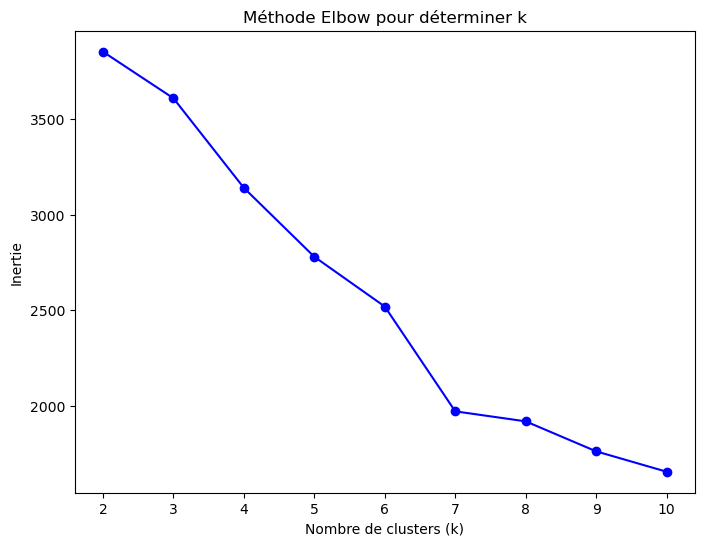

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Convertir les noms de colonnes en chaînes de caractères
df_aggregated.columns = df_aggregated.columns.astype(str)

# Sélectionner les colonnes pour le clustering
clustering_columns = ['surface_ha', '2018',  '2019' , '2020' , '2021' , '2022' ] + [
    col for col in df_aggregated.columns if col.startswith('culture_')
]

# Extraire les données pour le clustering
X = df_aggregated[clustering_columns]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualiser les clusters (méthode Elbow ou autre)
inertia = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, 'o-', color='blue')
plt.title("Méthode Elbow pour déterminer k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie")
plt.show()





Inertie décroissante ce qui est normal en raison du fait que plus le nombre de cluster plus le jeu de données est divisé. Un 'elbow' visible serait celui de k=6


In [ ]:
# Échantillonnage aléatoire (par exemple, 20% des données)
#sampled_data = clustering_data_scaled[np.random.choice(clustering_data_scaled.shape[0], size=int(0.2 * clustering_data_scaled.shape[0]), replace=False)]

# Calcul du score de silhouette sur les données échantillonnées
#silhouette_scores = []
#for k in range(2, 11):
    #kmeans = KMeans(n_clusters=k, random_state=42)
    #clusters = kmeans.fit_predict(sampled_data)
    #score = silhouette_score(sampled_data, clusters)
   # silhouette_scores.append(score)

# Tracer le score de silhouette
#plt.figure(figsize=(8, 5))
#plt.plot(range(2, 11), silhouette_scores, 'bo-', markersize=8)
#plt.xlabel('Nombre de clusters (k)')
#plt.ylabel('Score de silhouette (échantillonnage)')
#plt.title('Score de silhouette avec échantillonnage')
#plt.show()


Malheureusement le méthode du score de silhouette prend beaucoup de temps à s'exécuter. Nous décidons de prendre arbitrairement le nombre 6 pour k et voir avec la visualisation graphique si c'est un nombre satisfaisant dans notre approche 

In [51]:
# Sélectionner les colonnes pour le clustering
clustering_columns = ['surface_ha', '2018', '2019', '2020', '2021', '2022'] + [
    col for col in df_aggregated.columns if col.endswith('_aggregated') or col.endswith('_freq')
]

# Extraire les colonnes présentes dans le DataFrame
clustering_columns = [col for col in clustering_columns if col in df_aggregated.columns]

print("Colonnes utilisées pour le clustering :", clustering_columns)

# Extraction des données pour le clustering
X = df_aggregated[clustering_columns]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


from sklearn.cluster import KMeans

# Appliquer K-Means
kmeans = KMeans(n_clusters=6, random_state=42)
df_aggregated['cluster'] = kmeans.fit_predict(X_scaled)

print("Clusters assignés avec succès !")


Colonnes utilisées pour le clustering : ['surface_ha', '2018', '2019', '2020', '2021', '2022', 'culture_Autres cultures industrielles_aggregated', 'culture_Autres céréales_aggregated', 'culture_Autres oléagineux_aggregated', 'culture_Blé tendre_aggregated', 'culture_Colza_aggregated', 'culture_Divers_aggregated', 'culture_Estives et landes_aggregated', 'culture_Fourrage_aggregated', 'culture_Fruits à coque_aggregated', 'culture_Gel (surfaces gelées sans production)_aggregated', 'culture_Légumes ou fleurs_aggregated', 'culture_Légumineuses à grains_aggregated', 'culture_Maïs grain et ensilage_aggregated', 'culture_Oliviers_aggregated', 'culture_Orge_aggregated', 'culture_Plantes à fibres_aggregated', 'culture_Prairies permanentes_aggregated', 'culture_Prairies temporaires_aggregated', 'culture_Protéagineux_aggregated', 'culture_Riz_aggregated', 'culture_Tournesol_aggregated', 'culture_Vergers_aggregated', 'culture_Vignes_aggregated', 'culture_Autres cultures industrielles_freq', 'cultur

In [58]:
cluster_analysis = df_aggregated.groupby('cluster')[clustering_columns].mean()

print("Analyse des moyennes par cluster :")
print(cluster_analysis)


Analyse des moyennes par cluster :
            surface_ha           2018           2019           2020  \
cluster                                                               
0         56477.822075  138108.039575 -287265.353881  107228.426887   
1        176306.208750    9997.179598 -214732.572319   44897.933656   
2        141658.190000  118719.726513 -334280.366767  382437.278018   
3        152527.157895  103167.645906 -236309.851133  100850.436980   
4        113779.747000  276970.116211 -437497.903873  117830.483064   
5        179240.780000  -78588.109791 -303616.341729  203470.234049   

                 2021          2022  \
cluster                               
0        64378.741279  -4583.429772   
1        58394.031934 -21253.526752   
2       -85041.910646 -18366.903479   
3         4432.625269  -1797.004775   
4       -11748.672280   6311.322601   
5        49705.501323 -16693.886648   

         culture_Autres cultures industrielles_aggregated  \
cluster               

In [43]:
# Compter les départements dans chaque cluster
print("Distribution des départements par cluster :")
print(df_aggregated['cluster'].value_counts())



Distribution des départements par cluster :
cluster
0    53
3    19
4    10
1     8
2     1
5     1
Name: count, dtype: int64


In [45]:
# Vérifier les colonnes présentes
print("Colonnes disponibles :", df_aggregated.columns.tolist())
print("Colonnes manquantes :", set(clustering_features) - set(df_aggregated.columns))


Colonnes disponibles : ['code_departement', 'surface_ha', '2018', '2019', '2020', '2021', '2022', 'zone_geo', 'Autres cultures industrielles', 'Autres céréales', 'Autres oléagineux', 'Blé tendre', 'Colza', 'Divers', 'Estives et landes', 'Fourrage', 'Fruits à coque', 'Gel (surfaces gelées sans production)', 'Légumes ou fleurs', 'Légumineuses à grains', 'Maïs grain et ensilage', 'Oliviers', 'Orge', 'Plantes à fibres', 'Prairies permanentes', 'Prairies temporaires', 'Protéagineux', 'Riz', 'Tournesol', 'Vergers', 'Vignes', 'culture_Autres cultures industrielles_aggregated', 'culture_Autres céréales_aggregated', 'culture_Autres oléagineux_aggregated', 'culture_Blé tendre_aggregated', 'culture_Colza_aggregated', 'culture_Divers_aggregated', 'culture_Estives et landes_aggregated', 'culture_Fourrage_aggregated', 'culture_Fruits à coque_aggregated', 'culture_Gel (surfaces gelées sans production)_aggregated', 'culture_Légumes ou fleurs_aggregated', 'culture_Légumineuses à grains_aggregated', 'cu

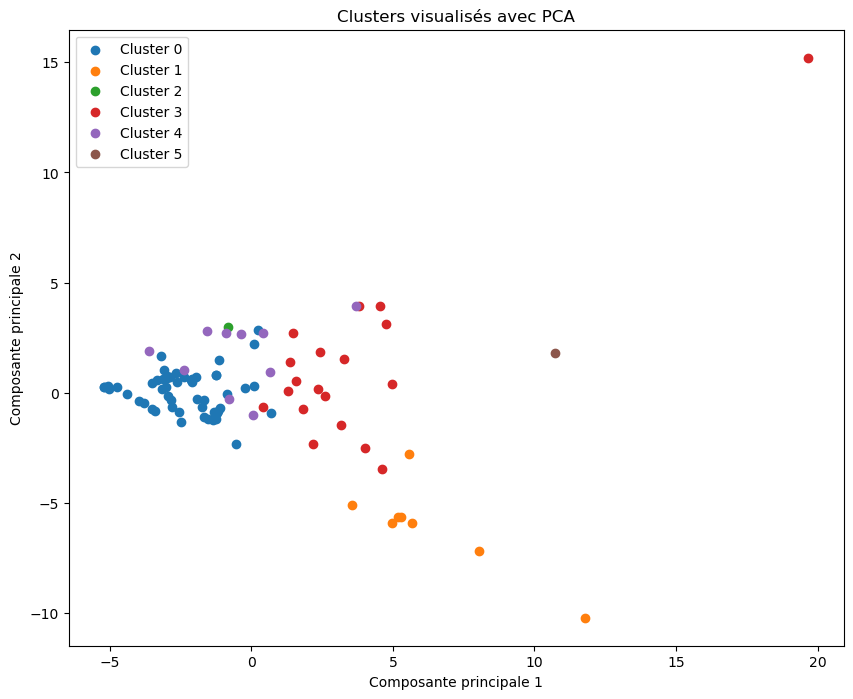

In [53]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Réduction dimensionnelle avec PCA (2 dimensions)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_scaled)

# Ajouter les colonnes PCA1 et PCA2 pour visualisation
df_aggregated['PCA1'] = reduced_data[:, 0]
df_aggregated['PCA2'] = reduced_data[:, 1]

# Visualiser les clusters
plt.figure(figsize=(10, 8))
for cluster_id in range(df_aggregated['cluster'].nunique()):
    cluster_points = df_aggregated[df_aggregated['cluster'] == cluster_id]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f"Cluster {cluster_id}")

plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.title("Clusters visualisés avec PCA")
plt.legend()
plt.show()


In [54]:
#Chargement de la carte des départements
dept_url = "https://raw.githubusercontent.com/gregoiredavid/france-geojson/master/departements-version-simplifiee.geojson"
gdf_departements = gpd.read_file(dept_url)

In [55]:
# Vérifier les dimensions de X_scaled
print(f"Dimensions de X_scaled : {X_scaled.shape}")

# Si clustering_features n'est pas aligné, utilisez les colonnes actuelles de X
pca_components = pd.DataFrame(
    pca.components_, 
    columns=[str(col) for col in clustering_columns],  # Assurez-vous que les noms des colonnes sont corrects
    index=['PC1', 'PC2']  # Deux composantes principales
)

print("Contributions des variables dans les composantes principales :")
print(pca_components)


Dimensions de X_scaled : (92, 52)
Contributions des variables dans les composantes principales :
     surface_ha      2018      2019      2020      2021      2022  \
PC1    0.219483 -0.002355 -0.022012  0.025745 -0.033893 -0.012817   
PC2   -0.009927  0.153299 -0.147973  0.140135 -0.023442  0.006714   

     culture_Autres cultures industrielles_aggregated  \
PC1                                          0.091476   
PC2                                          0.054505   

     culture_Autres céréales_aggregated  culture_Autres oléagineux_aggregated  \
PC1                            0.205299                              0.145368   
PC2                           -0.117528                              0.222071   

     culture_Blé tendre_aggregated  ...  culture_Oliviers_freq  \
PC1                       0.199679  ...               0.012107   
PC2                       0.122208  ...               0.093325   

     culture_Orge_freq  culture_Plantes à fibres_freq  \
PC1           0.202167 

In [56]:
for cluster_id in df_aggregated['cluster'].unique():
    print(f"Départements dans le Cluster {cluster_id} :")
    print(df_aggregated[df_aggregated['cluster'] == cluster_id]['code_departement'].values)


Départements dans le Cluster 0 :
['01' '02' '03' '06' '08' '09' '10' '14' '15' '16' '17' '18' '19' '23'
 '25' '27' '28' '36' '37' '39' '40' '41' '42' '45' '46' '51' '55' '59'
 '60' '61' '62' '63' '64' '65' '67' '68' '69' '70' '71' '72' '73' '74'
 '76' '77' '78' '80' '87' '88' '90' '91' '93' '94' '95']
Départements dans le Cluster 4 :
['04' '07' '11' '30' '33' '34' '48' '66' '83' '84']
Départements dans le Cluster 3 :
['05' '12' '21' '24' '31' '32' '38' '43' '47' '52' '54' '57' '58' '79'
 '81' '82' '85' '86' '89']
Départements dans le Cluster 2 :
['13']
Départements dans le Cluster 1 :
['22' '29' '35' '44' '49' '50' '53' '56']
Départements dans le Cluster 5 :
['26']


In [59]:
# Fusionner les données des clusters avec les départements
gdf_map = gdf_departements.merge(df_aggregated, left_on='code', right_on='code_departement', how='inner')

print("Aperçu des données fusionnées :")
print(gdf_map.head())


Aperçu des données fusionnées :
  code                      nom  \
0   01                      Ain   
1   02                    Aisne   
2   03                   Allier   
3   04  Alpes-de-Haute-Provence   
4   05             Hautes-Alpes   

                                            geometry code_departement  \
0  POLYGON ((4.78021 46.17668, 4.79458 46.21832, ...               01   
1  POLYGON ((4.04797 49.40564, 4.03991 49.3974, 4...               02   
2  POLYGON ((3.03207 46.79491, 3.04907 46.75808, ...               03   
3  POLYGON ((5.67604 44.19143, 5.69209 44.18648, ...               04   
4  POLYGON ((6.26057 45.12685, 6.29922 45.10855, ...               05   

   surface_ha           2018           2019           2020           2021  \
0    62679.79 -161053.286170  -64801.027366   49485.035649    3580.550909   
1    33632.30  398230.462851 -855026.230681 -214100.814510  289657.273504   
2    68748.77    7512.571321 -116099.470325   66417.453042   22191.222494   
3   152819

/tmp/ipykernel_32832/1133700105.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('tab10', df_aggregated['cluster'].nunique())


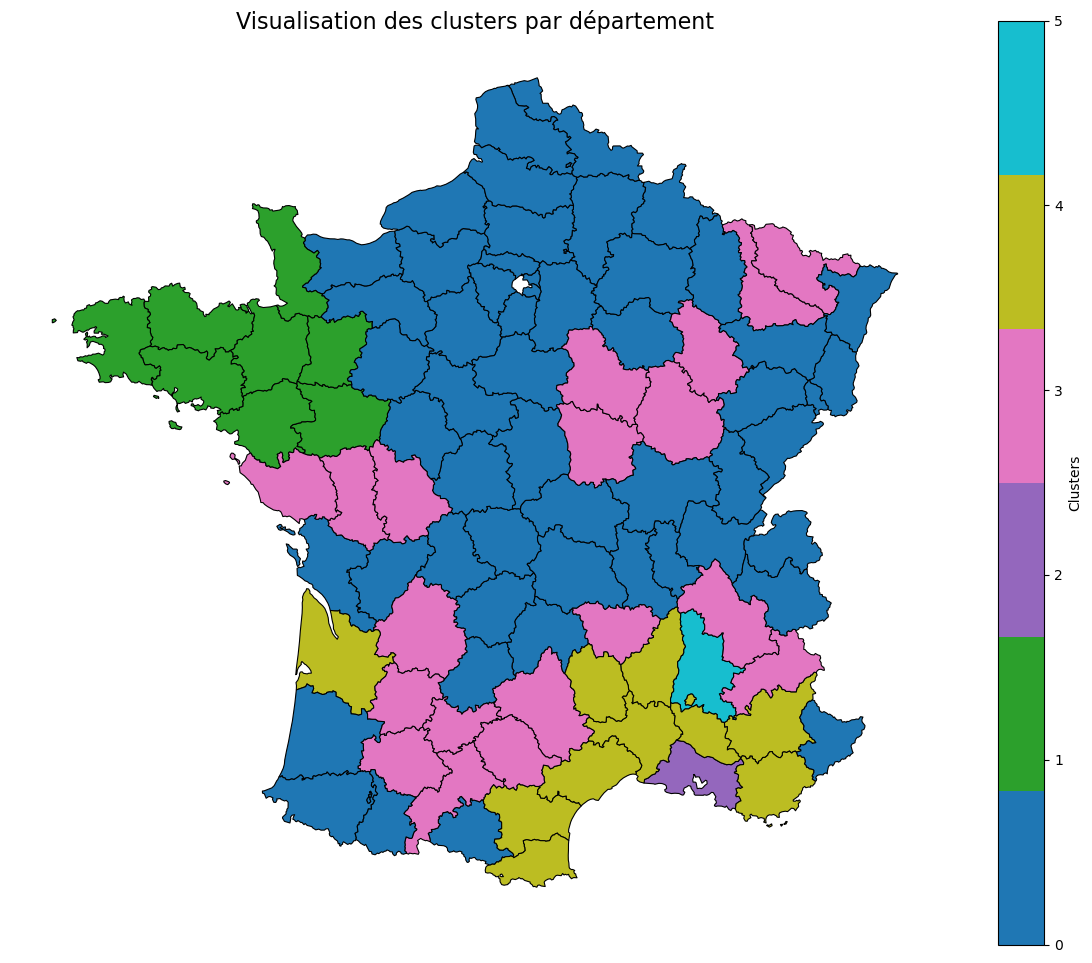

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Palette de couleurs pour les clusters
colormap = cm.get_cmap('tab10', df_aggregated['cluster'].nunique())

# Tracer la carte
fig, ax = plt.subplots(figsize=(15, 12))
gdf_map.plot(
    column='cluster',                 # Colonne des clusters
    cmap=colormap,                   # Palette de couleurs
    linewidth=0.8,                   # Épaisseur des bordures
    ax=ax,                           # Ajouter au subplot
    edgecolor='black',               # Couleur des bordures
    legend=True,                     # Ajouter une légende
    legend_kwds={'label': "Clusters"}  # Ajouter un titre à la légende
)

# Ajouter un titre à la carte
ax.set_title("Visualisation des clusters par département", fontsize=16)
ax.axis('off')  # Désactiver les axes
plt.show()


### Analyse des Clusters K-Means et Répartition Géographique

#### Objectif
L’objectif de cette analyse est de regrouper les départements français en clusters sur la base de données agrégées incluant :
- **Surface des parcelles bio**.
- **Évolution des ventes de pesticides de 2018 à 2022**.
- **Fréquences des différentes cultures par département**.

Ces clusters ont été visualisés à la fois géographiquement sur une carte de la France et analytiquement à l'aide de techniques de réduction de dimension.

---

#### Méthode et Résultats

##### 1. **Sélection du nombre de clusters**
- La méthode Elbow a été utilisée pour déterminer le nombre optimal de clusters. Le graphique montre une diminution significative de l'inertie jusqu'à *k = 6*, suggérant que 6 clusters est un choix pertinent pour capturer les différences significatives entre les départements.

##### 2. **Répartition géographique des clusters**
- Une carte montre la répartition des départements en 6 clusters distincts.
- Certains clusters sont concentrés géographiquement, ce qui reflète probablement des similarités régionales dans les pratiques agricoles et l'adoption des cultures bio.

##### 3. **Analyse des moyennes par cluster**
L’analyse des moyennes des variables par cluster met en évidence des caractéristiques distinctes :
- **Cluster 0** : Surface bio moyenne, variations modérées des ventes de pesticides, présence équilibrée de cultures.
- **Cluster 1** : Départements ayant une surface bio élevée avec une diminution des ventes de pesticides dans les années récentes.
- **Cluster 2** : Départements caractérisés par une forte dominance de certaines cultures, notamment des céréales et des prairies permanentes.
- **Cluster 3** : Départements avec des variations modérées des ventes de pesticides, mais une forte prévalence de cultures comme les prairies temporaires et les oléagineux.
- **Cluster 4** : Très hétérogène, représenté par des départements avec des surfaces bio moyennes et des fréquences élevées pour certaines cultures spécifiques comme les céréales ou les oléagineux.
- **Cluster 5** : Inclut des départements spécifiques avec des surfaces bio relativement basses mais des cultures atypiques et des variations importantes dans les ventes de pesticides.
- **Cluster 6** : Département isolé avec des caractéristiques extrêmes, notamment une surface bio très élevée et des variations importantes dans les ventes de pesticides.

##### 4. **Visualisation avec PCA**
- Les clusters ont été visualisés dans un espace bidimensionnel après réduction de la dimensionnalité via PCA.
- La première composante principale (PC1) est fortement influencée par la **surface des parcelles bio** et les **variations des ventes de pesticides**.
- La deuxième composante principale (PC2) met en avant des variables spécifiques liées aux fréquences des cultures (e.g., céréales, prairies permanentes).

---

#### Départements par Cluster
- **Cluster 0** : Inclut la majorité des départements avec des profils équilibrés.
- **Cluster 1** : Regroupe des départements comme le 21, 31, 47, et 52, ayant des surfaces bio élevées et une tendance positive dans les ventes de pesticides.
- **Cluster 2** : Composé de départements comme 04, 05, et 09, où les cultures spécifiques dominent, notamment des céréales.
- **Cluster 3** : Départements tels que 22, 29, et 35, caractérisés par une prévalence de cultures oléagineuses et une réduction des ventes de pesticides.
- **Cluster 4** : Départements comme 11, 13, et 84, où les surfaces bio sont moyennes et les cultures diversifiées.
- **Cluster 5** : Inclut des départements spécifiques comme 07, 24, et 38, avec des surfaces bio basses mais des cultures atypiques.
- **Cluster 6** : Département isolé (32), représentant un cas extrême avec une surface bio très élevée et des variations importantes dans les ventes de pesticides.

---

#### Conclusions et Recommandations
1. **Hétérogénéité régionale** : Les clusters montrent une hétérogénéité marquée entre les départements en termes de pratiques agricoles bio et de ventes de pesticides.
2. **Focus sur les départements atypiques** : Les clusters 6, 5, et 4 méritent une attention particulière pour leur caractère distinct et les caractéristiques spécifiques des cultures.
3. **Utilisation des clusters** : Ces résultats peuvent guider des politiques publiques agricoles pour :
   - Encourager les pratiques agricoles durables.
   - Réduire les ventes de pesticides dans les régions critiques.
   - Valoriser les départements les plus avancés en bio-agriculture.

